In [1]:
# import talos as ta
# from talos.model.early_stopper import early_stopper
# from talos.model.normalizers import lr_normalizer

import pylab as pl
import datetime
import pandas as pd
import itertools
from itertools import cycle
import pickle
import random as rn
import os

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.lines import Line2D

import sklearn
from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, Conv1D, Deconvolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.text import *
from keras.utils import np_utils
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.optimizers import Adam, Nadam, SGD
from keras.losses import categorical_crossentropy, logcosh

from time import time
from time import strftime
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

Using TensorFlow backend.


In [2]:
# os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
# session_conf = tf.ConfigProto(device_count = {'GPU':0}, intra_op_parallelism_threads=4) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# session_conf = tf.ConfigProto(device_count = {'GPU':0}) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# sess = tf.Session(graph=tf.get_default_graph())
# K.set_session(sess)

In [3]:
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos.dat", '\t')
df.head(10)

df = df[df['RearCnd']!='VF']

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))

X = df.iloc[:,5:]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

Species
AA    15030
AC     4401
AG    12545
dtype: int64
Status
BF     6361
GR     6188
SF    19427
dtype: int64
RearCnd
TF     6495
TL    25481
dtype: int64
Age
1      852
2      812
3     1035
4     1263
5     1736
6     1719
7     2020
8     2078
9     2255
10    2149
11    2328
12    2120
13    2432
14    2168
15    2345
16    2232
17    2432
dtype: int64
shape of X : (31976, 1650)
shape of y age : (31976,)
shape of y species : (31976,)
shape of y status : (31976,)


In [4]:
print('Unique Species : {}'.format(np.unique(y_species)))
print('Unique Status : {}'.format(np.unique(y_status)))
print('Unique Age : {}'.format(np.unique(y_age)))

print('{} - {}'.format(np.unique(y_species)[0],np.unique(y_species)[1]))
print('{} - {}'.format(len(y_species[y_species==np.unique(y_species)[0]]),len(y_species[y_species==np.unique(y_species)[1]])))

print('{} - {} - {}'.format(np.unique(y_status)[0],np.unique(y_status)[1],np.unique(y_status)[2]))
print('{} - {} - {}'.format(len(y_status[y_status==np.unique(y_status)[0]]),len(y_status[y_status==np.unique(y_status)[1]]),len(y_status[y_status==np.unique(y_status)[2]])))


Unique Species : ['AA' 'AC' 'AG']
Unique Status : ['BF' 'GR' 'SF']
Unique Age : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
AA - AC
15030 - 4401
BF - GR - SF
6361 - 6188 - 19427


In [5]:
def plot_spectrum_data():
    mosqdata_headers = list(mosqdata)[4:]
    mosqdata_vals = mosqdata[mosqdata_headers]
    meanARspec = {}
    meanKSspec = {}
    for head in mosqdata_headers:
        meanARspec[head] = np.mean(mosqdata[mosqdata['Species'] == 'AR'][[head]].as_matrix())
        meanKSspec[head] = np.mean(mosqdata[mosqdata['Species'] == 'KS'][[head]].as_matrix())
    #print(meanARspec)
    data = {"ARx":[], "ARy":[], "KSx":[], "KSy":[]}
    for label, vals in meanARspec.items():
        data["ARx"].append(int(label))
        data["ARy"].append(vals)
    for label, vals in meanKSspec.items():
        data["KSx"].append(int(label))
        data["KSy"].append(vals)
    AR = plt.scatter(data["ARx"], data["ARy"])
    KS = plt.scatter(data["KSx"], data["KSy"])
    plt.legend((AR, KS),('AR', 'KS'))
    plt.show()

In [6]:
def build_folder(fold, to_build = False):
    if not os.path.isdir(fold):
        if to_build == True:
            os.mkdir(fold)
        else:
            print('Directory does not exists, not creating directory!')
    else:
        if to_build == True:
            raise NameError('Directory already exists, cannot be created!')

In [7]:
def plot_confusion_matrix(cm, classes, output, save_path, model_name, fold,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printout=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printout:
            print("Normalized confusion matrix")
    else:
        if printout:
            print('Confusion matrix, without normalization')

    if printout:
        print(cm)
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(np.sum(cm, axis=1)))
    plt.title([title+' - '+model_name])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout(pad=1.2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((save_path+"Confusion_Matrix_"+model_name+"_"+fold+"_"+output[1:]+".png"))
    plt.close()

In [8]:
## for visualizing losses and metrics once the neural network fold is trained
def visualize(histories, save_path, model_name, fold, classes, outputs, predicted, true):
    # Sort out predictions and true labels
    for label_predictions_arr, label_true_arr, classes, outputs in zip(predicted, true, classes, outputs):
        classes_pred = np.argmax(label_predictions_arr, axis=-1)
        classes_true = np.argmax(label_true_arr, axis=-1)
        cnf_matrix = confusion_matrix(classes_true, classes_pred)
        plot_confusion_matrix(cnf_matrix, classes, outputs, save_path, model_name, fold)

In [9]:
## for logging data associated with the model
def log_data(log, name, fold, save_path):
    f = open((save_path+name+'_'+str(fold)+'_log.txt'), 'w')
    np.savetxt(f, log)
    f.close()

In [10]:
def graph_history(history, model_name, model_ver_num, fold, save_path):
    #not_validation = list(filter(lambda x: x[0:3] != "val", history.history.keys()))
    print('history.history.keys : {}'.format(history.history.keys()))
    filtered = filter(lambda x: x[0:3] != "val", history.history.keys())
    not_validation = list(filtered)
    for i in not_validation:
        plt.figure(figsize=(15,7))
        plt.title(i+"/ "+"val_"+i)
        plt.plot(history.history[i], label=i)
        plt.plot(history.history["val_"+i], label="val_"+i)
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(i)
        plt.savefig(save_path +model_name+"_"+str(model_ver_num)+"_"+str(fold)+"_"+i)
        plt.close()

In [11]:
input_layer_dim = len(X[0])

## Ages transformed
y_age_list = [[age] for age in y_age]
y_species_list = [[species] for species in y_species]
y_status_list = [[status] for status in y_status]
age = MultiLabelBinarizer().fit_transform(np.array(y_age_list))
age_classes = list(np.unique(y_age_list))
species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
species_classes = list(np.unique(y_species_list))
status = MultiLabelBinarizer().fit_transform(np.array(y_status_list))
status_classes = list(np.unique(y_status_list))
  
## Labels default - all classification
labels_default, classes_default, outputs_default = [age, species, status], [age_classes, species_classes, status_classes], ['xAge', 'xSpecies', 'xStatus']
# labels_default, classes_default, outputs_default = [age], [age_classes], ['xAge']

model_name = 'CNN'
label = labels_default

## Scale train, test
scl = StandardScaler()
features = scl.fit_transform(X=X)   
        
fold = 1

## Split data into 1:9 ratio for training/testing
test_splits = train_test_split(features, *(labels_default), test_size=0.1, shuffle=True, random_state=42)

X_train = test_splits.pop(0)
X_test = test_splits.pop(0)
y_train = test_splits[::2]
y_test = test_splits[1::2]

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

## Split into training / testing
test_splits = train_test_split(X_train, *(y_train), test_size=0.25, shuffle=True, random_state=42)
## Pack up data
X_train = test_splits.pop(0)
X_val = test_splits.pop(0)
y_train = test_splits[::2]
y_val = test_splits[1::2]


In [12]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
# from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [13]:
def CNN_model(kernel_1, strides_1, pool_1,
              kernel_2, strides_2, pool_2,
              kernel_3, strides_3, pool_3,
              kernel_4, strides_4, pool_4,
              kernel_5, strides_5, pool_5):
    
    try:
        input_vec = Input(name='input', shape=(1650,1))

        xd = Conv1D(name='Conv_1', filters=16,
         kernel_size = int(kernel_1), strides = int(strides_1),
#          kernel_size = int(kernel_1), strides = 1,
         activation='relu',
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(input_vec)
        xd = BatchNormalization(name='batchnorm_1')(xd)
        xd = MaxPooling1D(pool_size=int(pool_1))(xd)

        xd = Conv1D(name='Conv_2', filters=16,
         kernel_size = int(kernel_2), strides = int(strides_2),
#          kernel_size = int(kernel_2), strides = 1,
         activation='relu',
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name='batchnorm_2')(xd)
        xd = MaxPooling1D(pool_size=int(pool_2))(xd)

        xd = Conv1D(name='Conv_3', filters=16,
         kernel_size = int(kernel_3), strides = int(strides_3),
#          kernel_size = int(kernel_3), strides = 1,
         activation='relu',
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name='batchnorm_3')(xd)
        xd = MaxPooling1D(pool_size=int(pool_3))(xd)

        xd = Conv1D(name='Conv_4', filters=16,
         kernel_size = int(kernel_4), strides = int(strides_4),
#          kernel_size = int(kernel_4), strides = 1,
         activation='relu',
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name='batchnorm_4')(xd)
        xd = MaxPooling1D(pool_size=int(pool_4))(xd)

        xd = Conv1D(name='Conv_5', filters=16,
         kernel_size = int(kernel_5), strides = int(strides_5),
#          kernel_size = int(kernel_5), strides = 1,
         activation='relu',
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name='batchnorm_5')(xd)
        xd = MaxPooling1D(pool_size=int(pool_5))(xd)

        xd = Flatten()(xd)

        xd = Dropout(name='dout_6', rate=0.5)(xd)
        xd = Dense(name='d_6', units=500, activation='relu', 
         kernel_regularizer=l2(0.02), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name='batchnorm_6')(xd)  


        xAge     = Dense(name = 'age', units = 17, 
                         activation = 'softmax', 
                         kernel_regularizer = l2(0.02), 
                         kernel_initializer = 'he_normal')(xd)
        xSpecies = Dense(name ='species', units = 3, 
                         activation = 'softmax', 
                         kernel_regularizer = l2(0.02), 
                         kernel_initializer = 'he_normal')(xd)
        xStatus  = Dense(name='status', units = 3, 
                         activation = 'softmax', 
                         kernel_regularizer = l2(0.02), 
                         kernel_initializer = 'he_normal')(xd)

        outputs = []
        for i in ['xAge', 'xSpecies', 'xStatus']:
    #     for i in ['xAge']:
            outputs.append(locals()[i])
        model = Model(inputs = input_vec, outputs = outputs)

        model.compile(loss=categorical_crossentropy, metrics=['acc'], 
                      optimizer=SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True))
#     model.summary()

    except:
        model = -1

    return model

In [14]:
kernel_1 = Integer(low=3, high=9, name='kernel_1')
strides_1 = Integer(low=1, high=2, name='strides_1')
pool_1 = Integer(low=1, high=2, name='pool_1')
kernel_2 = Integer(low=3, high=9, name='kernel_2')
strides_2 = Integer(low=1, high=2, name='strides_2')
pool_2 = Integer(low=1, high=2, name='pool_2')
kernel_3 = Integer(low=3, high=9, name='kernel_3')
strides_3 = Integer(low=1, high=2, name='strides_3')
pool_3 = Integer(low=1, high=2, name='pool_3')
kernel_4 = Integer(low=3, high=9, name='kernel_4')
strides_4 = Integer(low=1, high=2, name='strides_4')
pool_4 = Integer(low=1, high=2, name='pool_4')
kernel_5 = Integer(low=3, high=9, name='kernel_5')
strides_5 = Integer(low=1, high=2, name='strides_5')
pool_5 = Integer(low=1, high=2, name='pool_5')


dimensions = [kernel_1, 
              strides_1,
              pool_1,
              kernel_2, 
              strides_2,
              pool_2,
              kernel_3,
              strides_3,
              pool_3,
              kernel_4,
              strides_4,
              pool_4,
              kernel_5,
              strides_5,
              pool_5]


# default_parameters = [0.5, 200]

default_parameters = [5, 
                      1, 
                      2,
                      5, 
                      1, 
                      2,
                      5, 
                      1, 
                      2,
                      3, 
                      1, 
                      2,
                      3, 
                      1,
                      2]

path_best_model = 'CNN_best_model.keras'
best_accuracy = 0.0

In [15]:
@use_named_args(dimensions=dimensions)
def fitness(kernel_1, strides_1, pool_1,
            kernel_2, strides_2, pool_2,
            kernel_3, strides_3, pool_3,
            kernel_4, strides_4, pool_4,
            kernel_5, strides_5, pool_5):

    
    # Print the hyper-parameters.
    print('kernel_1: {}'.format(kernel_1))
    print('strides_1: {}'.format(strides_1))
    print('pool_1: {}'.format(pool_1))
    print('kernel_2: {}'.format(kernel_2))
    print('strides_2: {}'.format(strides_2))
    print('pool_2: {}'.format(pool_2))
    print('kernel_3: {}'.format(kernel_3))
    print('strides_3: {}'.format(strides_3))
    print('pool_3: {}'.format(pool_3))
    print('kernel_4: {}'.format(kernel_4))
    print('strides_4: {}'.format(strides_4))
    print('pool_4: {}'.format(pool_4))
    print('kernel_5: {}'.format(kernel_5))
    print('strides_5: {}'.format(strides_5))
    print('pool_5: {}'.format(pool_5))
    start_time = time()
    print('start time: {}'.format(strftime('%X %x %Z')))
    print()
    
    # Create the neural network with these hyper-parameters.
    model = CNN_model(kernel_1, strides_1, pool_1,
                      kernel_2, strides_2, pool_2,
                      kernel_3, strides_3, pool_3,
                      kernel_4, strides_4, pool_4,
                      kernel_5, strides_5, pool_5)

#     model.summary()
    
   
    # Use Keras to train the model.
    if model == -1:
        
        end_time = time()
        print('Run time : {} h'.format((end_time-start_time)/3600))
        
        accuracy = 0.0
        
    else:
        model.summary()
        history = model.fit(x = X_train, 
                            y = y_train,
                            batch_size = 2048, 
                            verbose = 0, 
                            epochs = 3000,
                            validation_data = (X_val, y_val),
                            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        patience=400, verbose=0, mode='auto'), 
                                        CSVLogger(model_name+'.csv', append=True, separator=';')])

        end_time = time()
        print('Run time : {} h'.format((end_time-start_time)/3600))

        # Get the classification accuracy on the validation-set
        # after the last training-epoch.
        accuracy = (history.history['val_age_acc'][-1] * 0.8) + (history.history['val_species_acc'][-1] * 0.1) + (history.history['val_status_acc'][-1] * 0.1)
        
    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [ ]:
fitness(x=default_parameters)

In [16]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=30,
                            x0=default_parameters)


kernel_1: 5
strides_1: 1
pool_1: 2
kernel_2: 5
strides_2: 1
pool_2: 2
kernel_3: 5
strides_3: 1
pool_3: 2
kernel_4: 3
strides_4: 1
pool_4: 2
kernel_5: 3
strides_5: 1
pool_5: 2
start time: 13:10:42 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1646, 16)     96          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1646, 16)     64          Conv_1[0][0]                     
_________________________________________________________________________________________________

Run time : 1.3348376374112234 h

Accuracy: 93.37%

kernel_1: 6
strides_1: 1
pool_1: 2
kernel_2: 6
strides_2: 2
pool_2: 1
kernel_3: 7
strides_3: 1
pool_3: 2
kernel_4: 9
strides_4: 2
pool_4: 2
kernel_5: 8
strides_5: 2
pool_5: 2
start time: 15:27:37 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1645, 16)     112         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1645, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.2636656753222149 h

Accuracy: 93.53%

kernel_1: 7
strides_1: 2
pool_1: 1
kernel_2: 4
strides_2: 1
pool_2: 2
kernel_3: 8
strides_3: 1
pool_3: 2
kernel_4: 9
strides_4: 2
pool_4: 1
kernel_5: 6
strides_5: 1
pool_5: 2
start time: 17:32:33 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 822, 16)      128         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 822, 16)      64          Conv_1[0][0]                     
______________________________________________

Run time : 0.7004708335796992 h

Accuracy: 59.04%

kernel_1: 4
strides_1: 2
pool_1: 2
kernel_2: 6
strides_2: 2
pool_2: 1
kernel_3: 6
strides_3: 2
pool_3: 1
kernel_4: 9
strides_4: 1
pool_4: 1
kernel_5: 4
strides_5: 1
pool_5: 1
start time: 18:58:41 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 824, 16)      80          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 824, 16)      64          Conv_1[0][0]                     
______________________________________________

Run time : 0.5138227993249893 h

Accuracy: 79.22%

kernel_1: 3
strides_1: 1
pool_1: 2
kernel_2: 5
strides_2: 2
pool_2: 1
kernel_3: 7
strides_3: 1
pool_3: 2
kernel_4: 5
strides_4: 1
pool_4: 1
kernel_5: 8
strides_5: 2
pool_5: 1
start time: 20:00:39 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1648, 16)     64          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1648, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.2808360195159911 h

Accuracy: 93.88%

kernel_1: 5
strides_1: 1
pool_1: 2
kernel_2: 8
strides_2: 1
pool_2: 1
kernel_3: 6
strides_3: 2
pool_3: 1
kernel_4: 3
strides_4: 1
pool_4: 2
kernel_5: 4
strides_5: 1
pool_5: 1
start time: 22:09:11 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1646, 16)     96          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1646, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 0.7443855709499783 h

Accuracy: 92.36%

kernel_1: 9
strides_1: 1
pool_1: 1
kernel_2: 5
strides_2: 2
pool_2: 2
kernel_3: 8
strides_3: 2
pool_3: 1
kernel_4: 3
strides_4: 2
pool_4: 1
kernel_5: 8
strides_5: 2
pool_5: 2
start time: 23:59:52 01/09/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1642, 16)     160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1642, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.2954554596212176 h

Accuracy: 92.81%

kernel_1: 5
strides_1: 2
pool_1: 1
kernel_2: 6
strides_2: 1
pool_2: 2
kernel_3: 3
strides_3: 2
pool_3: 2
kernel_4: 4
strides_4: 2
pool_4: 2
kernel_5: 3
strides_5: 1
pool_5: 1
start time: 02:13:44 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 823, 16)      96          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 823, 16)      64          Conv_1[0][0]                     
______________________________________________

Run time : 0.7295906394057804 h

Accuracy: 92.70%

kernel_1: 9
strides_1: 1
pool_1: 1
kernel_2: 5
strides_2: 2
pool_2: 2
kernel_3: 8
strides_3: 2
pool_3: 2
kernel_4: 8
strides_4: 2
pool_4: 2
kernel_5: 3
strides_5: 1
pool_5: 1
start time: 03:37:21 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1642, 16)     160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1642, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.1740654280450609 h

Accuracy: 90.19%

kernel_1: 9
strides_1: 1
pool_1: 1
kernel_2: 7
strides_2: 1
pool_2: 2
kernel_3: 6
strides_3: 1
pool_3: 1
kernel_4: 6
strides_4: 1
pool_4: 2
kernel_5: 9
strides_5: 1
pool_5: 2
start time: 05:42:29 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1642, 16)     160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1642, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 0.7292072651783625 h

Accuracy: 91.09%

kernel_1: 9
strides_1: 2
pool_1: 1
kernel_2: 3
strides_2: 1
pool_2: 2
kernel_3: 9
strides_3: 1
pool_3: 2
kernel_4: 9
strides_4: 2
pool_4: 1
kernel_5: 9
strides_5: 1
pool_5: 1
start time: 08:02:25 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 821, 16)      160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 821, 16)      64          Conv_1[0][0]                     
______________________________________________

Run time : 1.1414393934276368 h

Accuracy: 93.33%

kernel_1: 3
strides_1: 1
pool_1: 1
kernel_2: 3
strides_2: 2
pool_2: 2
kernel_3: 9
strides_3: 2
pool_3: 2
kernel_4: 5
strides_4: 2
pool_4: 1
kernel_5: 3
strides_5: 2
pool_5: 1
start time: 09:56:03 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1648, 16)     64          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1648, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.2665838692585627 h

Accuracy: 92.60%

kernel_1: 9
strides_1: 1
pool_1: 1
kernel_2: 9
strides_2: 1
pool_2: 2
kernel_3: 3
strides_3: 1
pool_3: 1
kernel_4: 3
strides_4: 1
pool_4: 1
kernel_5: 9
strides_5: 1
pool_5: 2
start time: 12:06:30 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1642, 16)     160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1642, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.9402756790982352 h

Accuracy: 93.72%

kernel_1: 5
strides_1: 1
pool_1: 2
kernel_2: 3
strides_2: 1
pool_2: 2
kernel_3: 9
strides_3: 1
pool_3: 2
kernel_4: 3
strides_4: 1
pool_4: 2
kernel_5: 6
strides_5: 2
pool_5: 1
start time: 15:45:19 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1646, 16)     96          input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1646, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 0.9204586842987272 h

Accuracy: 91.52%

kernel_1: 9
strides_1: 1
pool_1: 1
kernel_2: 9
strides_2: 1
pool_2: 1
kernel_3: 9
strides_3: 1
pool_3: 1
kernel_4: 9
strides_4: 1
pool_4: 1
kernel_5: 9
strides_5: 1
pool_5: 2
start time: 17:35:35 01/10/19 -01

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1650, 1)      0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 1642, 16)     160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1642, 16)     64          Conv_1[0][0]                     
______________________________________________

Run time : 1.9118166890409258 h

Accuracy: 93.07%



In [17]:
from skopt import dump
dump(search_result, 'search_result_store')

In [ ]:
# from skopt import load
# search_result_load = load("search_result_store")

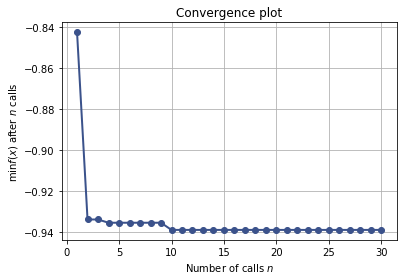

In [18]:
plot_convergence(search_result)
plt.savefig("convergence.png")

In [ ]:
# search_result.x
# space = search_result.space
# space.point_to_dict(search_result.x)

In [ ]:
# sorted_results = sorted(zip(search_result.func_vals, search_result.x_iters))
# # print(sorted_results)
# f = open("search_results.txt", "w")
# for res in sorted_results:
# #     np.savetxt("search_results.txt", res)
#     f.write('{}, {}\n'.format(res[0], res[1]))

In [ ]:
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()
